In [1]:
import torch
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood
from gpzoo.pri_experiment_utilities import build_model, model_grads
from torch.distributions import Normal
import matplotlib.pyplot as plt
from torch import nn, distributions, optim
from tqdm.autonotebook import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from sklearn.decomposition import NMF

# Data Generation 
from sklearn.datasets import make_blobs

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
torch.manual_seed(256)
random_seed = 256

In [12]:
# define training loop
def train_batched(model, optimizer, X, y, device, steps=200, E=20, verbose=False, batch_size=1000, **kwargs):

    kwargs = kwargs['kwargs']
    losses = []
    means = []
    scales = []
    idxs = []

    for it in tqdm(range(steps)):
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward_batched(X=X, idx=idx, E=E, verbose=verbose, kwargs=kwargs)
        
        logpY = y[:, idx]*torch.log(pY.rate) - (pY.rate)

        ELBO = ((logpY).mean(axis=0).sum()).to(device)
        ELBO -= torch.sum(torch.vmap(vnngp_kl)(qU.mean, qU.scale_tril, model.prior.Lu, model.prior.mu))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales, idxs

In [13]:
def plot_factors_five(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = factors.shape[1]

    if ax is None:
        fig, ax = plt.subplots(1, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(1, 5, i+1)
        
        curr_ax = ax[i]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)
        #plt.scatter(X[:, 0], X[:, 1], x=factors[i], cmap='magma')

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

### Gaussian Blobs

In [ ]:
# Parameters
n_samples = 3000
n_features = 15
centers = 10
cluster_std = 2.0

# Generate Gaussian blobs
Y, X = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std, random_state=random_seed)

# Ensure all values are positive by adding an offset
offset = np.abs(Y.min(axis=0)) + 1
Y = Y + offset

# Plot Gaussian blobs
plt.scatter(Y[:, 0], Y[:, 1], c=X, cmap='magma')
plt.title('Gaussian Blobs')
plt.show()

In [14]:
# NMF
nmf_model = NMF(n_components=5, max_iter=1000, init='random', random_state=256, alpha_H=2e-1, alpha_W=1e-7)

In [15]:
print(X.shape)
print(Y.shape)

(3000,)
(3000, 15)


In [16]:
nmf_model.fit(Y)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=1000, n_components=5,
    random_state=256)

In [17]:
factors = nmf_model.transform(Y)
loadings = nmf_model.components_

In [18]:
factors.shape

(3000, 5)

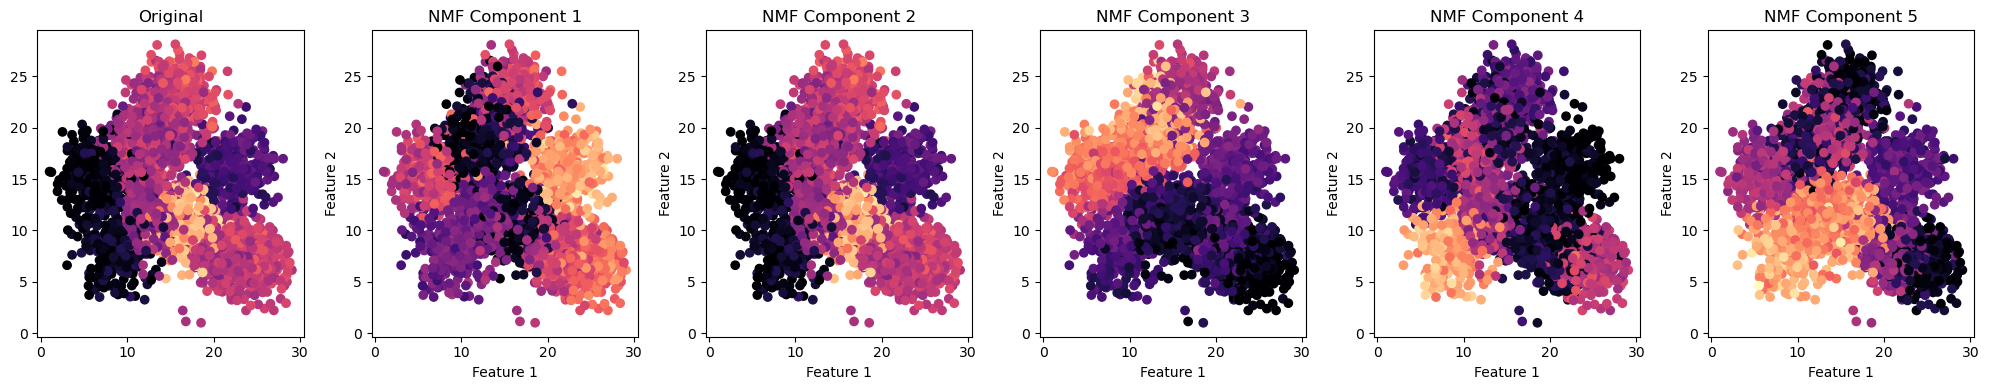

In [35]:
# Create subplots
fig, axes = plt.subplots(1, 5 + 1, figsize=(20, 4))

# Plot original data
axes[0].scatter(Y[:, 0], Y[:, 1], c=factors[:,1], cmap='magma')
axes[0].set_title('Original')
#axes[0].set_xlabel('Feature 1')
#axes[0].set_ylabel('Feature 2')

# Plot each NMF component
for i in range(5):
    axes[i + 1].scatter(Y[:, 0], Y[:, 1], c=factors[:, i], cmap='magma')
    axes[i + 1].set_title(f'NMF Component {i + 1}')
    axes[i + 1].set_xlabel('Feature 1')
    axes[i + 1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

### GGblocks

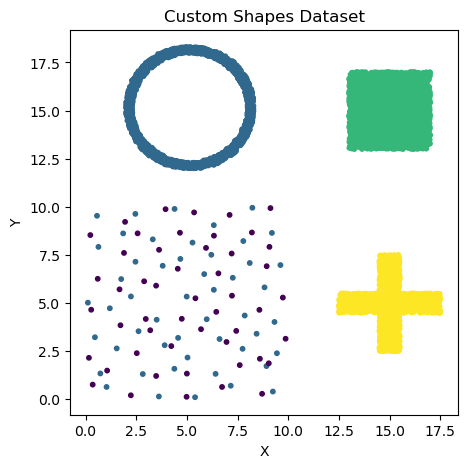

In [38]:
# Function to generate checkerboard pattern
def generate_checkerboard(n_samples, size, block_size):
    checkerboard = np.indices((size, size)).sum(axis=0) % 2
    points = []
    labels = []
    for i in range(size):
        for j in range(size):
            if len(points) < n_samples:
                points.append([i * block_size + np.random.rand() * block_size,
                               j * block_size + np.random.rand() * block_size])
                labels.append(checkerboard[i, j])
    return np.array(points), np.array(labels)

# Function to generate circular pattern
def generate_circle(n_samples, radius, center):
    angles = np.linspace(0, 2 * np.pi, n_samples)
    points = np.array([[center[0] + radius * np.cos(a) + np.random.rand() * radius * 0.1,
                        center[1] + radius * np.sin(a) + np.random.rand() * radius * 0.1]
                       for a in angles])
    labels = np.ones(n_samples) * 1
    return points, labels

# Function to generate square pattern
def generate_square(n_samples, side_length, center):
    points = []
    labels = np.ones(n_samples) * 2
    while len(points) < n_samples:
        x = center[0] - side_length / 2 + np.random.rand() * side_length
        y = center[1] - side_length / 2 + np.random.rand() * side_length
        points.append([x, y])
    return np.array(points), labels

# Function to generate cross pattern
def generate_cross(n_samples, width, length, center):
    points = []
    labels = np.ones(n_samples) * 3
    half_width = width / 2
    half_length = length / 2
    while len(points) < n_samples:
        if np.random.rand() > 0.5:
            x = center[0] - half_length + np.random.rand() * length
            y = center[1] - half_width + np.random.rand() * width
        else:
            x = center[0] - half_width + np.random.rand() * width
            y = center[1] - half_length + np.random.rand() * length
        points.append([x, y])
    return np.array(points), labels

# Parameters
n_samples_per_shape = 3000
size = 10
block_size = 1
circle_radius = 3
square_side_length = 4
cross_width = 1
cross_length = 5
center_circle = [5, 15]
center_square = [15, 15]
center_cross = [15, 5]

# Generate data for each shape
points_checkerboard, labels_checkerboard = generate_checkerboard(n_samples_per_shape, size, block_size)
points_circle, labels_circle = generate_circle(n_samples_per_shape, circle_radius, center_circle)
points_square, labels_square = generate_square(n_samples_per_shape, square_side_length, center_square)
points_cross, labels_cross = generate_cross(n_samples_per_shape, cross_width, cross_length, center_cross)

# Combine all points and labels
points = np.vstack([points_checkerboard, points_circle, points_square, points_cross])
labels = np.concatenate([labels_checkerboard, labels_circle, labels_square, labels_cross])

# Plot the data
plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Custom Shapes Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [61]:
noise_level = 0.4
noisy_points = points + np.random.normal(scale=noise_level, size=points.shape)

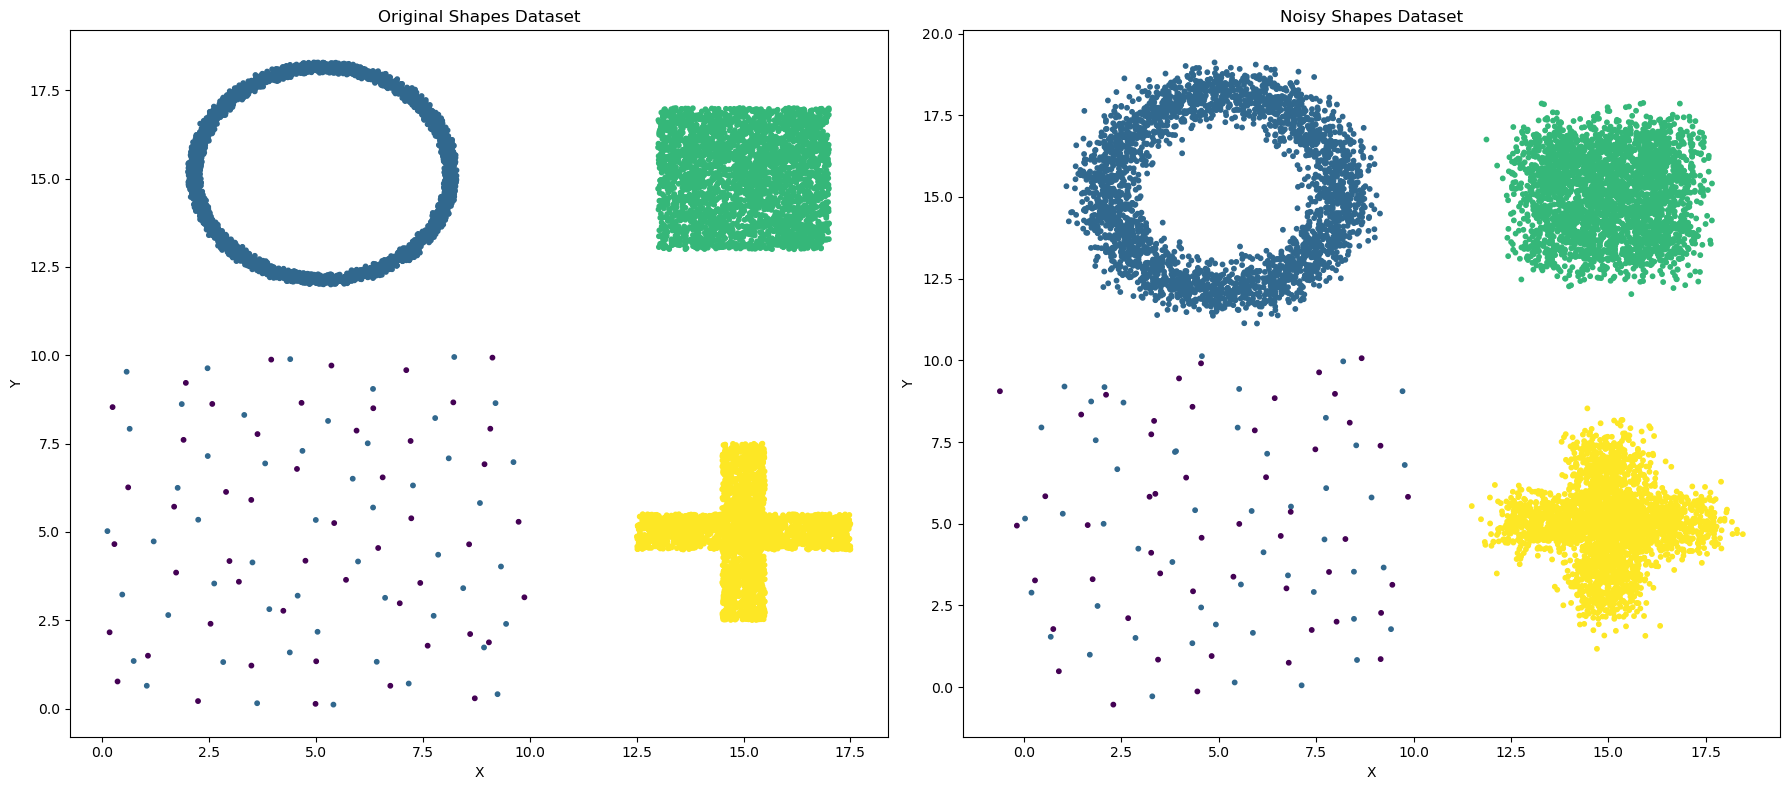

In [63]:
# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot original data
axes[0].scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=10)
axes[0].set_title('Original Shapes Dataset')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Plot noisy data
axes[1].scatter(noisy_points[:, 0], noisy_points[:, 1], c=labels, cmap='viridis', s=10)
axes[1].set_title('Noisy Shapes Dataset')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

plt.tight_layout()
plt.show()

In [64]:
print(noisy_points.shape)
print(labels.shape)

(9100, 2)
(9100,)


In [78]:
X = points
Y = labels
Y = Y[:, None]

In [79]:
nmf_model = NMF(n_components=4, max_iter=1000, init='random', random_state=256)

In [80]:
nmf_model.fit(Y)

NMF(init='random', max_iter=1000, n_components=4, random_state=256)

In [81]:
factors = nmf_model.transform(Y)
loadings = nmf_model.components_

In [82]:
factors.shape

(9100, 4)

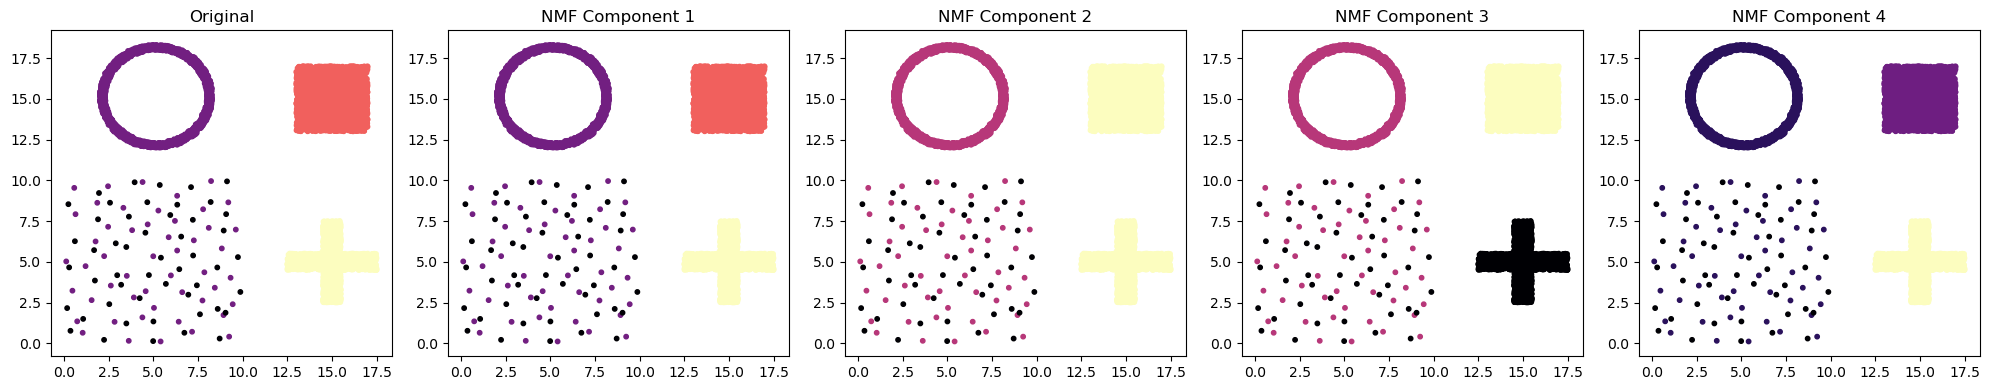

In [83]:
# Create subplots
fig, axes = plt.subplots(1, 4 + 1, figsize=(20, 4))

# Plot original data
axes[0].scatter(X[:, 0], X[:, 1], c=Y, cmap='magma', s=10)
axes[0].set_title('Original')
#axes[0].set_xlabel('Feature 1')
#axes[0].set_ylabel('Feature 2')

# Plot each NMF component
for i in range(4):
    axes[i + 1].scatter(X[:, 0], X[:, 1], c=factors[:, i], cmap='magma', s=10)
    axes[i + 1].set_title(f'NMF Component {i + 1}')

plt.tight_layout()
plt.show()

### Extra

In [ ]:
# make models
model = build_model(X, y, factors=, lodaings=, model_type='VNNGP', kwargs=train_dict)
model.to(device)
X_train = X.to(device)
Y_train = Y.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

model.to(device)
start_time = time.time()
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=100, E=10)
end_time = time.time()
final_time = end_time - start_time
exp_data['time'].append(final_time)

In [40]:
train_dict = {
    'L': 10, 
    'M': 3000, 
    'K': 8,
    'sigma': 0.01, 
    'lengthscale': 0.07, 
    'jtr': 1e-2,
    'batch_size': 3000,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
}

IndexError: index 1 is out of bounds for axis 1 with size 1

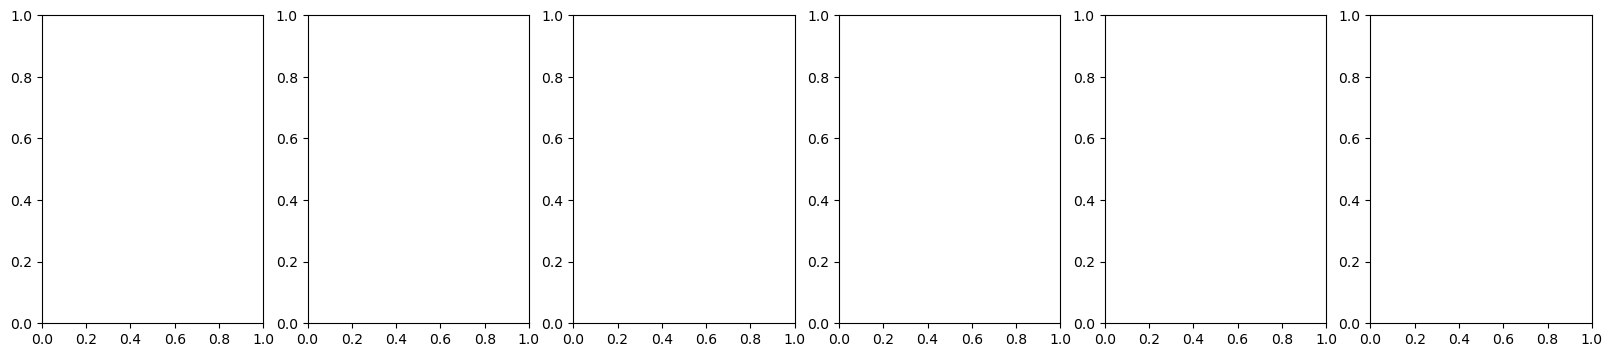

In [7]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []
    idxs = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, verbose=True, lkzz_build = 2, **kwargs)

        logpY = pY.log_prob(y)
        print("Shape of y:", y.shape)
        print("Expected shape by model output:", pY.mean.shape)  # Assuming pY is a distribution

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [8]:
num_N = [1000] #2000, 5000, 10000, 15000]

In [9]:
exp_data = {
    'model' :  [],
    'N' : [],
    'Z' : [],
    'L' : [],
    'time' : []
}

K:  5
Z Shape:  torch.Size([1000, 1])
Lu Shape:  torch.Size([1000, 1000])
Mu: Shape  torch.Size([1000])


  0%|          | 0/100 [00:00<?, ?it/s]

Kxx shape before contiguous().view(-1, 1):  torch.Size([3, 5000])
calculating Kxx
Kxx.shape torch.Size([15000, 1])
Kxz shape before contiguous().view(-1, 1):  torch.Size([3, 5000, 1000])
distances shape::  torch.Size([5000, 1000])
calculating Kxz
Kxz.shape torch.Size([15000, 1000])
Kzz shape before contiguous().view(..):  torch.Size([3, 1000, 1000])
calculating kzz
Kzz.shape torch.Size([3, 1000, 1000])
indexes.shape:  torch.Size([5000, 5])
Little_Kzz.shape: torch.Size([5000, 3, 5, 5])
W_shape: torch.Size([15000, 1, 5])
torch.Size([15000, 1]) torch.Size([15000, 5, 5]) torch.Size([15000, 1, 5]) torch.Size([15000, 5]) torch.Size([15000, 5, 5])
mean.shape: torch.Size([15000, 1, 1])
cov.shape: torch.Size([15000, 1])
Shape of y: torch.Size([3, 5000])
Expected shape by model output: torch.Size([10, 3, 5000])
Kxx shape before contiguous().view(-1, 1):  torch.Size([3, 5000])
calculating Kxx
Kxx.shape torch.Size([15000, 1])
Kxz shape before contiguous().view(-1, 1):  torch.Size([3, 5000, 1000])


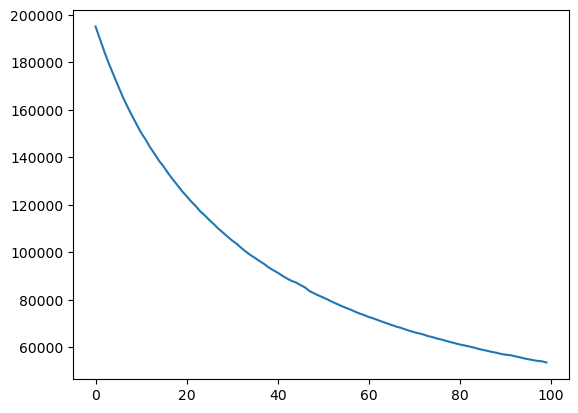

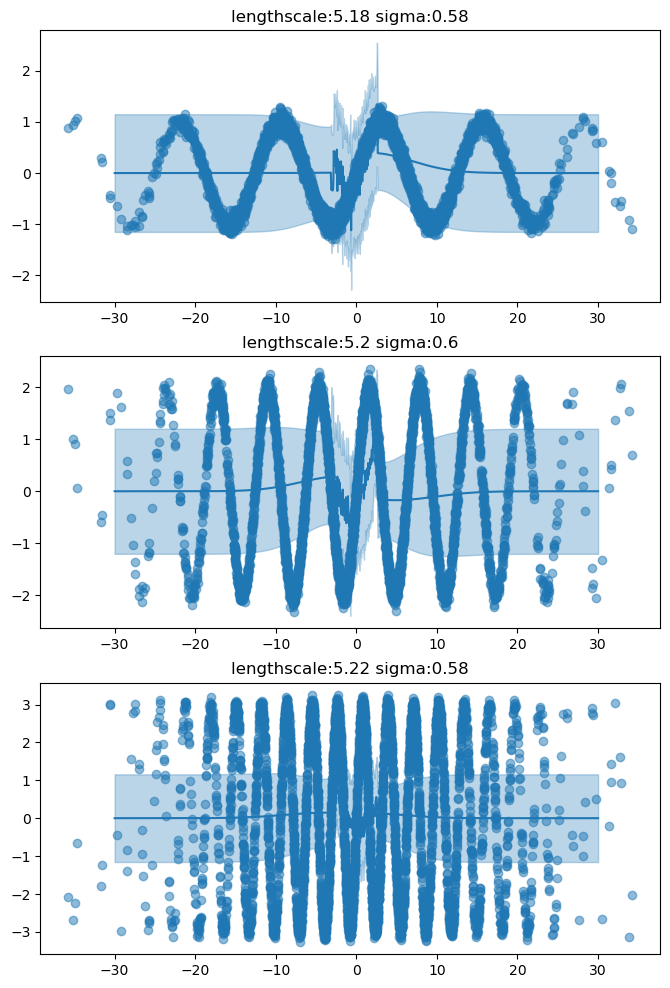

In [10]:
torch.manual_seed(21)

for i in range(1):
    X, Y = make_data(D=3, N=5000)
    X = X[:, None]

    # initialize dictionary
    L = 3
    M = 1000

    dx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
    gp = VNNGP(kernel, M=M, jitter=1e-1, K=5)
    gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
    gp.mu = nn.Parameter(torch.randn((L, M)))
    #gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST

    # update data dictionary
    exp_data['L'].append(L)
    exp_data['Z'].append(M)
    exp_data['N'].append(num_N[i])
    alg = 'VNNGP'
    exp_data['model'].append(alg)

    model = GaussianLikelihood(gp=gp, noise=0.1)
    model.to(device)
    X_train = X.to(device)
    Y_train = Y.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

    model.to(device)
    start_time = time.time()
    losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=100, E=10)
    end_time = time.time()
    final_time = end_time - start_time
    exp_data['time'].append(final_time)


    # save losses
    fig1, ax1 = plt.subplots()
    plt.plot(losses)
    #fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
    #plt.close(fig1)

    # save test figure
    model.cpu()
    X_test= torch.linspace(-30, 30, 2000)[:, None]
    qF, qU, pU = model.gp(X_test)

    fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
    for j in range(3):
      ax = ax2[j]  # Use the ith subplot's axes for plotting
      mean = qF.mean.detach().cpu().numpy()[j]
      sd = qF.scale.detach().cpu().numpy()[j]
      ax.plot(X_test, mean)
      ax.scatter(X, Y[j], alpha=0.5)
      ax.fill_between(
            X_test[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
      ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))
    fig2.savefig(f'{alg}_N={num_N[i]}_Z={M}_test.png')

    # save model
   #torch.save(model.state_dict(), f'{alg}_N={num_N[i]}_Z={M}.pth')


In [11]:
X_test = torch.linspace(-30, 30, 5000)[:, None]

def plot(curr_mean, curr_scale, ax2):
    #ax2.clear()  # Clear the axes to redraw
    for j in range(3):
        ax = ax2[j]  # Use the ith subplot's axes for plotting
        mean = curr_mean[j]
        sd = curr_scale[j]
        ax.plot(X_test.cpu().numpy(), mean)  # Use X_test for plotting predictions
        #ax.scatter(X_train.cpu().numpy(), Y_train.cpu().numpy()[j], alpha=0.5)  # Adjust based on your Y_train shape
        ax.fill_between(
              X_test.cpu().numpy()[:, 0],  # Make sure X_test is 1D here
              (mean - 2.0 * sd),
              (mean + 2.0 * sd),
              color="C0",
              alpha=0.3,
          )
        ax.set_ylim([Y_train.min(), Y_train.max()])  # Optionally, set consistent y-limits
        ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))

In [12]:
# Modify the update function to clear axes
def update(iteration):
    curr_mean = means[iteration]
    curr_scale = scales[iteration]
    for ax in ax2:
        ax.clear()  # Clear each subplot
    plot(curr_mean, curr_scale, ax2=ax2)

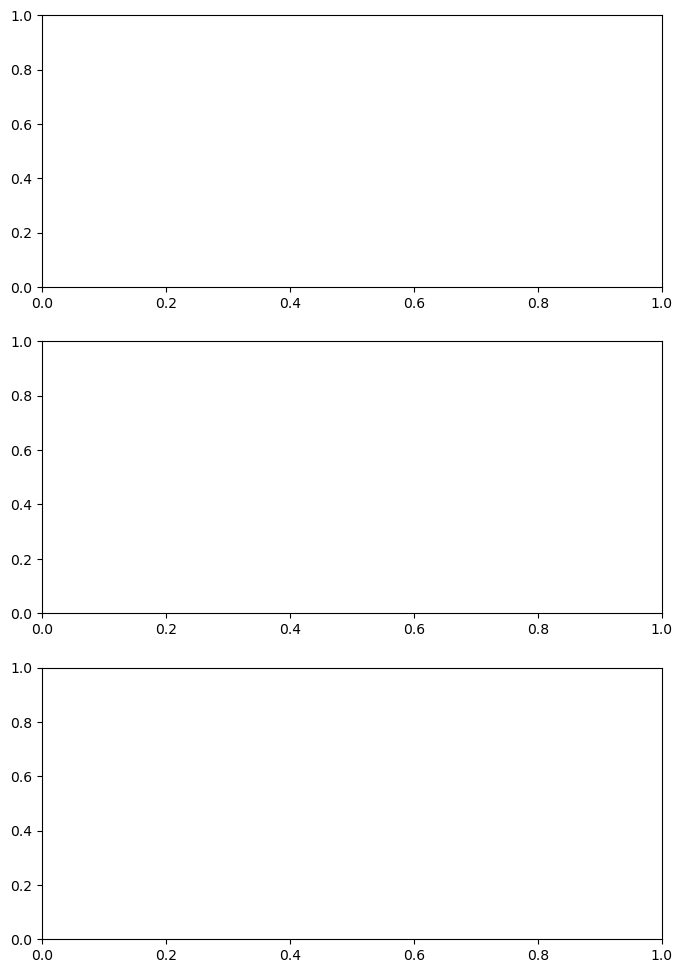

KeyboardInterrupt: 

In [13]:
fig, ax2 = plt.subplots(3, 1, figsize=(8, 12))
anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
#anim.save("VNNGP_anim_test.gif", writer='pillow', fps=10, dpi=50)

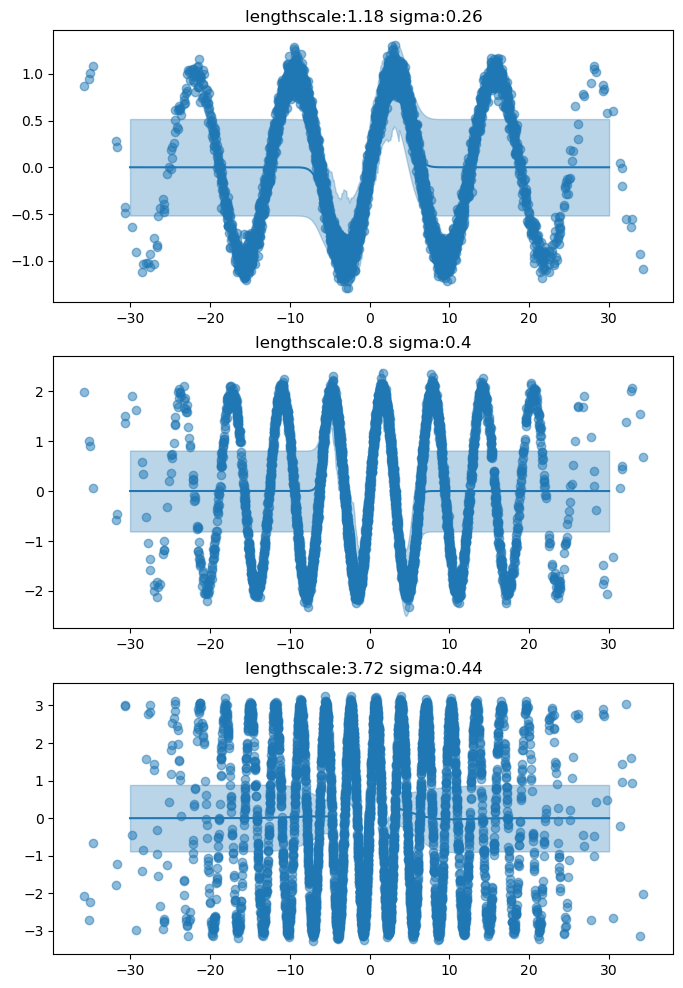

In [50]:
# save test figure
model.cpu()
X_test= torch.linspace(-30, 30, 1000)[:, None]
qF, qU, pU = model.gp(X_test)

fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
for j in range(3):
  ax = ax2[j]  # Use the ith subplot's axes for plotting
  mean = qF.mean.detach().cpu().numpy()[j]
  sd = qF.scale.detach().cpu().numpy()[j]
  ax.plot(X_test, mean)
  ax.scatter(X, Y[j], alpha=0.5)
  ax.fill_between(
  X_test[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
      (mean - 2.0 * sd),
      (mean + 2.0 * sd),
      color="C0",
      alpha=0.3,)
  ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))

In [21]:
means[0][0]

array([0.77064157, 0.5486614 , 1.1085385 , ..., 0.94941884, 0.34475577,
       0.5171135 ], dtype=float32)

In [ ]:
# save losses
fig1, ax1 = plt.subplots()
plt.plot(losses)
#fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
#plt.close(fig1)


In [ ]:
print(scales[0].shape)

In [ ]:
#X_test = torch.linspace(-30, 30, 1000)[:, None]
X_test = torch.linspace(-30, 30, 2000)[:, None]

def plot(curr_mean, curr_scale, ax2):
    for j in range(3):
      ax = ax2[j]  # Use the ith subplot's axes for plotting
      mean = curr_mean[j]
      sd = curr_scale[j]
      ax.plot(X_train, mean)
      ax.scatter(X_train, Y_train[j], alpha=0.5)
      ax.fill_between(
            X_train[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
      ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))


In [ ]:
fig, ax2 = plt.subplots(3, 1, figsize=(8, 12))

# Animation Test
def update(iteration):
  curr_mean = means[iteration]
  curr_scale = scales[iteration]
  plot(curr_mean, curr_scale, ax2=ax2)

anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
anim.save("VNNGP_anim_test.gif", writer='pillow', fps=10, dpi=50)

In [ ]:
X_test = torch.linspace(-30, 30, 2000)[:, None]

def plot(curr_mean, curr_scale, ax2):
    ax2.clear()  # Clear the axes to redraw
    for j in range(3):
        ax = ax2[j]  # Use the ith subplot's axes for plotting
        mean = curr_mean[j]
        sd = curr_scale[j]
        ax.plot(X_test.cpu().numpy(), mean)  # Use X_test for plotting predictions
        ax.scatter(X_train.cpu().numpy(), Y_train.cpu().numpy()[j], alpha=0.5)  # Adjust based on your Y_train shape
        ax.fill_between(
              X_test.cpu().numpy()[:, 0],  # Make sure X_test is 1D here
              (mean - 2.0 * sd),
              (mean + 2.0 * sd),
              color="C0",
              alpha=0.3,
          )
        ax.set_ylim([Y_train.min(), Y_train.max()])  # Optionally, set consistent y-limits
        ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))

In [ ]:
# Modify the update function to clear axes
def update(iteration):
    curr_mean = means[iteration]
    curr_scale = scales[iteration]
    for ax in ax2:
        ax.clear()  # Clear each subplot
    plot(curr_mean, curr_scale, ax2=ax2)

In [ ]:
anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
anim.save("VNNGP_anim_test.gif", writer='pillow', fps=10, dpi=50)

# SVGP

In [ ]:
for i in range(1):
    X, Y = make_data(D=3, N=1000)
    X = X[:, None]

    # initialize dictionary
    L = 3
    M = 100

    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
    gp = SVGP(kernel, jitter=1e-1)
    gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
    gp.mu = nn.Parameter(torch.randn((L, M)))
    gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)

    # update data dictionary
    exp_data['L'].append(L)
    exp_data['Z'].append(M)
    exp_data['N'].append(num_N[i])
    alg = 'SVGP'
    exp_data['model'].append(alg)

    model = GaussianLikelihood(gp=gp, noise=0.1)
    model.to(device)
    X_train = X.to(device)
    Y_train = Y.to(device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

    model.to(device)
    start_time = time.time()
    losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=2000, E=10)
    end_time = time.time()
    final_time = end_time - start_time
    exp_data['time'].append(final_time)
    '''
    # save losses
    fig1, ax1 = plt.subplots()
    plt.plot(losses)
    #fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
    plt.close(fig1)

    # save test figure
    model.cpu()
    X_test= torch.linspace(-30, 30, 1000)[:, None]
    qF, qU, pU = model.gp(X_test)

    fig2, ax2 = plt.subplots(3, 1, figsize=(8, 12))
    for j in range(3):
      ax = ax2[j]  # Use the ith subplot's axes for plotting
      mean = qF.mean.detach().cpu().numpy()[j]
      sd = qF.scale.detach().cpu().numpy()[j]
      print(mean.shape)
      print(sd.shape)
      ax.plot(X_test, mean)
      ax.scatter(X, Y[j], alpha=0.5)
      ax.fill_between(
            X_test[:, 0],  # Assuming X_test is a 2D array; adjust if necessary
            (mean - 2.0 * sd),
            (mean + 2.0 * sd),
            color="C0",
            alpha=0.3,
        )
      ax.set_title('lengthscale:'+str(np.round(model.gp.kernel.lengthscale[j].item(), 2))+' sigma:'+str(np.round(model.gp.kernel.sigma[j].item(), 2)))
    #fig2.savefig(f'{alg}_N={num_N[i]}_Z={M}_test.png')

    # save model
    #torch.save(model.state_dict(), f'{alg}_N={num_N[i]}_Z={M}.pth')
    '''


In [ ]:
plt.scatter(exp_data['N'][:5], exp_data['time'][:5], label="VNNGP")
plt.plot(exp_data['N'][:5], exp_data['time'][:5])
plt.scatter(exp_data['N'][5:], exp_data['time'][5:], label="SVGP")
plt.plot(exp_data['N'][5:], exp_data['time'][5:])
plt.title("Runtime with different N")
plt.xlabel("Number of Examples (N)")
plt.ylabel("Time (s)")
plt.legend()
plt.savefig("Runtime_changing_N")

In [ ]:
np.save('z_benchmarking.npy', exp_data)

In [ ]:
X_test = torch.linspace(-30, 30, 1000)[:, None]
fig, ax2 = plt.subplots(3, 1, figsize=(8, 12))

# Animation Test
def update(iteration):
  curr_mean = means[iteration]
  curr_scale = scales[iteration]
  plot(curr_mean, curr_scale, ax2=ax2)

anim = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()
anim.save("SVGP_anim_test.gif", writer='pillow', fps=10, dpi=50)